# P5: Disaster Classification

## Part 1: Aquire Data

To connect from terminal use:

    psql -h dsi.c20gkj5cvu3l.us-east-1.rds.amazonaws.com -p 5432 -U dsi_student titanic
    password: gastudents

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.cross_validation import train_test_split, cross_val_score
from sqlalchemy import create_engine
import csv
import os
import time
import sqlalchemy
import seaborn as sns
from pandas.tools.plotting import scatter_matrix
%matplotlib inline

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
connectStr = "postgresql://{}:{}@{}/{}".format(
            'dsi_student',
            'gastudents',
            'dsi.c20gkj5cvu3l.us-east-1.rds.amazonaws.com',
            'titanic'
        )
engine = create_engine( connectStr )

In [3]:
# query and aggregate
df = pd.read_sql('''SELECT
                "Embarked",
                "Survived",
                "Pclass",
                "Fare",
                "Sex",
                "Age",
                "SibSp",
                "Parch"
            FROM train''', engine)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Embarked    889 non-null object
Survived    891 non-null int64
Pclass      891 non-null int64
Fare        891 non-null float64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [5]:
# nulls, dups, recasts
df['Age'].fillna(round(df['Age'].mean()), inplace=True)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 771 entries, 0 to 890
Data columns (total 8 columns):
Embarked    771 non-null object
Survived    771 non-null int64
Pclass      771 non-null int64
Fare        771 non-null float64
Sex         771 non-null object
Age         771 non-null float64
SibSp       771 non-null int64
Parch       771 non-null int64
dtypes: float64(2), int64(4), object(2)
memory usage: 54.2+ KB


In [7]:
# risks and assumptions
# data dictionary

## Part 2: Exploratory Data Analysis

In [8]:
# describe data
df.describe(include='all')

,Embarked,Survived,Pclass,Fare,Sex,Age,SibSp,Parch
count,771,771.000000,771.000000,771.000000,771,771.000000,771.000000,771.000000
unique,3,NaN,NaN,NaN,2,NaN,NaN,NaN
top,S,NaN,NaN,NaN,male,NaN,NaN,NaN
freq,561,NaN,NaN,NaN,482,NaN,NaN,NaN
mean,NaN,0.413748,2.243839,34.942418,NaN,29.783943,0.530480,0.422827
std,NaN,0.492824,0.854445,52.460737,NaN,13.736799,0.992199,0.842197
min,NaN,0.000000,1.000000,0.000000,NaN,0.420000,0.000000,0.000000
25%,NaN,0.000000,1.000000,8.050000,NaN,21.000000,0.000000,0.000000
50%,NaN,0.000000,3.000000,16.100000,NaN,30.000000,0.000000,0.000000
75%,NaN,1.000000,3.000000,34.375000,NaN,36.000000,1.000000,1.000000


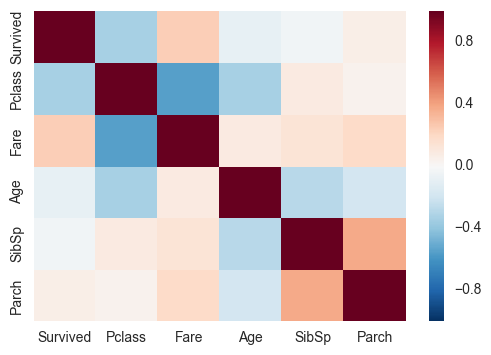

In [9]:
# DL. What does the heatmap tell you about the dataset?

# visualize data
sns.heatmap(df.corr())

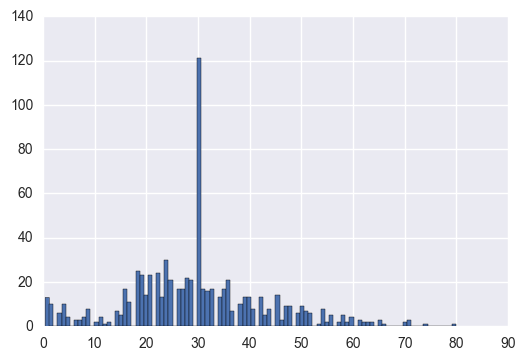

In [10]:
df['Age'].hist(bins=100)

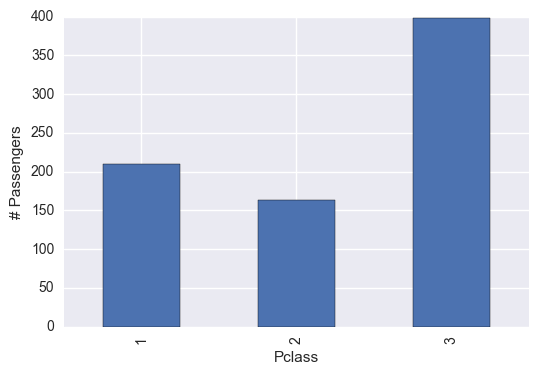

In [11]:
agg = df.groupby('Pclass').apply(len)
agg.plot(kind='bar').set_ylabel('# Passengers')

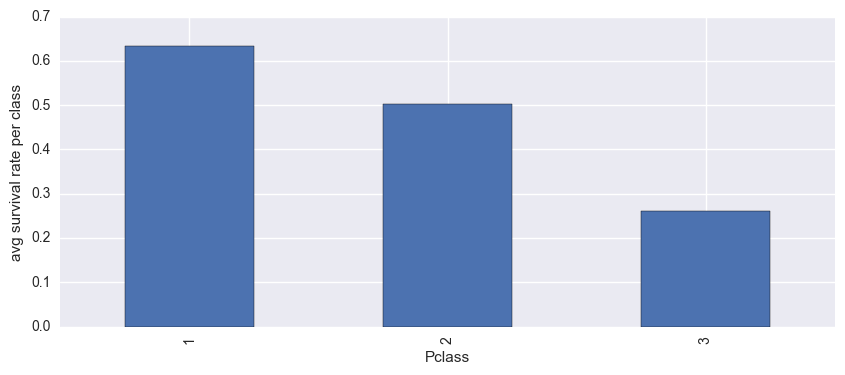

In [12]:
# DL. It's usually helpful to explain your graphs to your audience.
class_counts = df.groupby('Pclass')['Survived'].mean()
class_counts.sort_values(axis=0, ascending=False, inplace=True)
class_counts.plot(kind='bar', figsize=(10, 4)).set_ylabel('avg survival rate per class')

## Part 3: Data Wrangling

In [36]:
# DL. It's better practice to make sure all your code is visible.
# Instead of typing all you features on one line, try to break them down.
# You can use "\" is you're trying to break a string.

# patsy our design matrix
y, X = dmatrices("Survived ~ C(Sex, Treatment(reference='male')) \
                 + C(Pclass) + Age + SibSp + Parch + C(Embarked)", 
                 data = df, return_type = 'dataframe')

In [14]:
merged_df = X.copy()

In [15]:
# DL. instead of making a copy of X and then adding y, It's easier to just copy df.

merged_df['Survived'] = y

In [16]:
X.describe()

,Intercept,"C(Sex, Treatment(reference='male'))[T.female]",C(Pclass)[T.2],C(Pclass)[T.3],C(Embarked)[T.Q],C(Embarked)[T.S],Age,SibSp,Parch
count,771.0,771.000000,771.000000,771.000000,771.000000,771.000000,771.000000,771.000000,771.000000
mean,1.0,0.374838,0.211414,0.516213,0.073930,0.727626,29.783943,0.530480,0.422827
std,0.0,0.484395,0.408576,0.500061,0.261827,0.445470,13.736799,0.992199,0.842197
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.420000,0.000000,0.000000
25%,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,0.000000,0.000000
50%,1.0,0.000000,0.000000,1.000000,0.000000,1.000000,30.000000,0.000000,0.000000
75%,1.0,1.000000,0.000000,1.000000,0.000000,1.000000,36.000000,1.000000,1.000000
max,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,80.000000,8.000000,6.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117ead790>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1192e45d0>]], dtype=object)

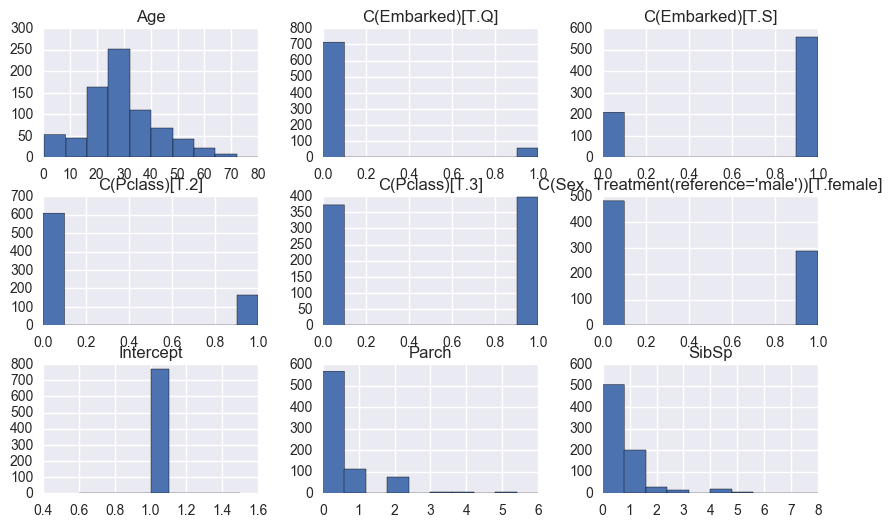

In [17]:
# DL. describe some insights that you found from your histograms.

X.hist(bins=10, figsize=(10, 6))

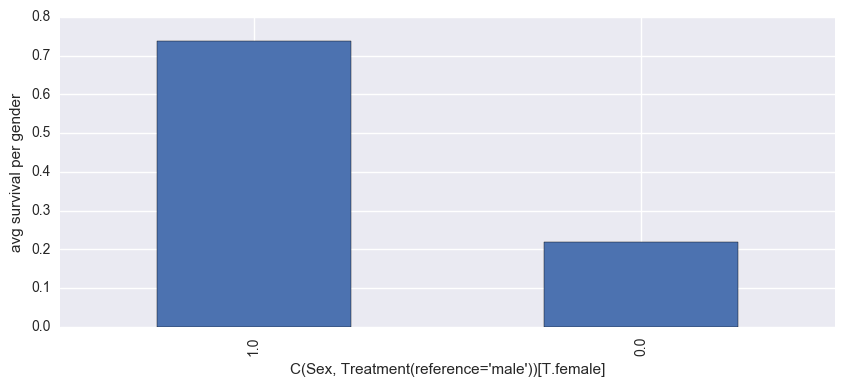

In [18]:
gender_counts = merged_df.groupby("C(Sex, Treatment(reference='male'))[T.female]")['Survived'].mean()
gender_counts.sort_values(axis=0, ascending=False, inplace=True)
gender_counts.plot(kind='bar', figsize=(10, 4)).set_ylabel('avg survival per gender')

In [19]:
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size = .3, stratify=y, random_state = 42)

In [20]:
# ravel y for sklearn
y_ravel = y.values.ravel()

## Part 4: Logistic Regression and Model Validation

In [21]:
# fit model
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
logreg = LogisticRegression()
logreg.fit(Xtr, ytr)
logreg_pred = logreg.predict(Xte)

//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [22]:
# cross validate test set
logregCV = LogisticRegressionCV(cv=5)
logregCV.fit(Xtr, ytr)

# predict class labels
logregCV_pred = logregCV.predict(Xte)

In [23]:
# classification report
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
target_names = ['dead', 'survived']
print 'logreg_accuracy:',accuracy_score(yte, logreg_pred)
print 'logreg_classification_report:'
print classification_report(yte, logreg_pred, target_names=target_names)
print 'logregCV_accuracy:',accuracy_score(yte, logregCV_pred)
print 'logregCV_classification_report:'
print classification_report(yte, logregCV_pred, target_names=target_names)

logreg_accuracy: 0.758620689655
logreg_classification_report:
             precision    recall  f1-score   support

       dead       0.77      0.85      0.80       136
   survived       0.74      0.64      0.69        96

avg / total       0.76      0.76      0.76       232


logregCV_accuracy: 0.758620689655
logregCV_classification_report:
             precision    recall  f1-score   support

       dead       0.75      0.88      0.81       136
   survived       0.77      0.59      0.67        96

avg / total       0.76      0.76      0.75       232



In [24]:
# examine coefficients
print X.columns
print logreg.coef_

Index([u'Intercept', u'C(Sex, Treatment(reference='male'))[T.female]',
       u'C(Pclass)[T.2]', u'C(Pclass)[T.3]', u'C(Embarked)[T.Q]',
       u'C(Embarked)[T.S]', u'Age', u'SibSp', u'Parch'],
      dtype='object')
[[ 0.5268586   2.3643735  -0.45478542 -1.55595461 -0.22190815 -0.40993346
  -0.03411707 -0.33420538  0.01033335]]


In [25]:
print X.columns
print logregCV.coef_

Index([u'Intercept', u'C(Sex, Treatment(reference='male'))[T.female]',
       u'C(Pclass)[T.2]', u'C(Pclass)[T.3]', u'C(Embarked)[T.Q]',
       u'C(Embarked)[T.S]', u'Age', u'SibSp', u'Parch'],
      dtype='object')
[[  9.65945425e-05   1.25850010e+00   5.73124463e-03  -7.07254543e-01
   -7.14507447e-02  -2.77384327e-01  -2.31907857e-02  -1.99530627e-01
    6.51400210e-02]]


#### What do the classification metrics tell us?

The classification metrics show us our scores for the different models, and we can see that in both models, they are fairly similar. However, looking further down below, we will see that the AUC for logreg model is slightly better than the logregCV. 

In [26]:
# confusion matrix
cm = confusion_matrix(yte, logreg_pred)
print "logreg_confusion_matrix"
pd.DataFrame(cm, index=target_names, columns=['predicted_'+x for x in target_names])

logreg_confusion_matrix


,predicted_dead,predicted_survived
dead,115,21
survived,35,61


In [27]:
cm = confusion_matrix(yte, logregCV_pred)
print "logregCV_confusion_matrix"
pd.DataFrame(cm, index=target_names, columns=['predicted_'+x for x in target_names])

logregCV_confusion_matrix


,predicted_dead,predicted_survived
dead,119,17
survived,39,57


#### What does the Confusion Matrix tell us? 

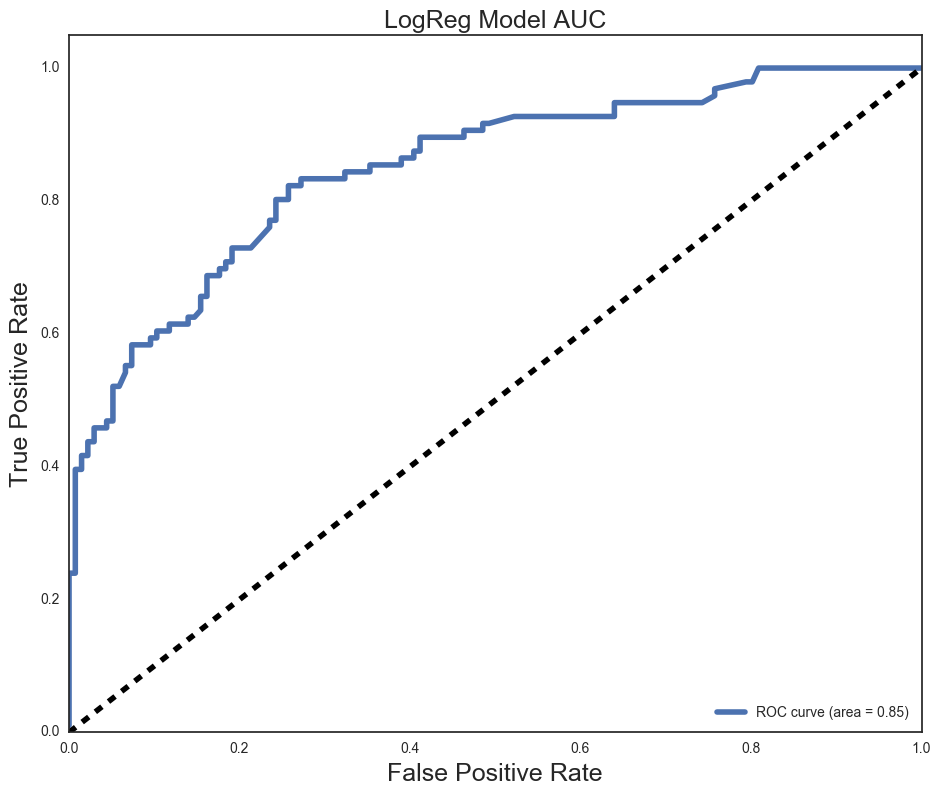

In [37]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline


Y_score = logreg.decision_function(Xte)

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(yte, Y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('LogReg Model AUC', fontsize=18)
plt.legend(loc="lower right")
plt.show()

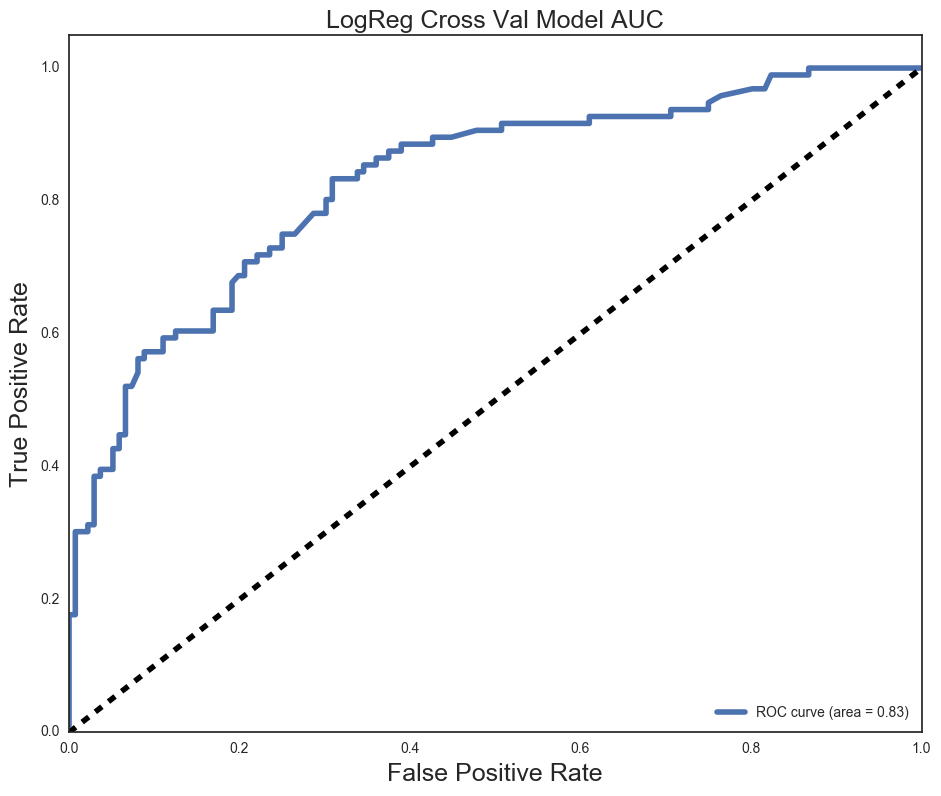

In [29]:
# plot and explain the ROC curve
# plot and explain the ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline


Y_score = logregCV.decision_function(Xte)

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(yte, Y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('LogReg Cross Val Model AUC', fontsize=18)
plt.legend(loc="lower right")
plt.show()

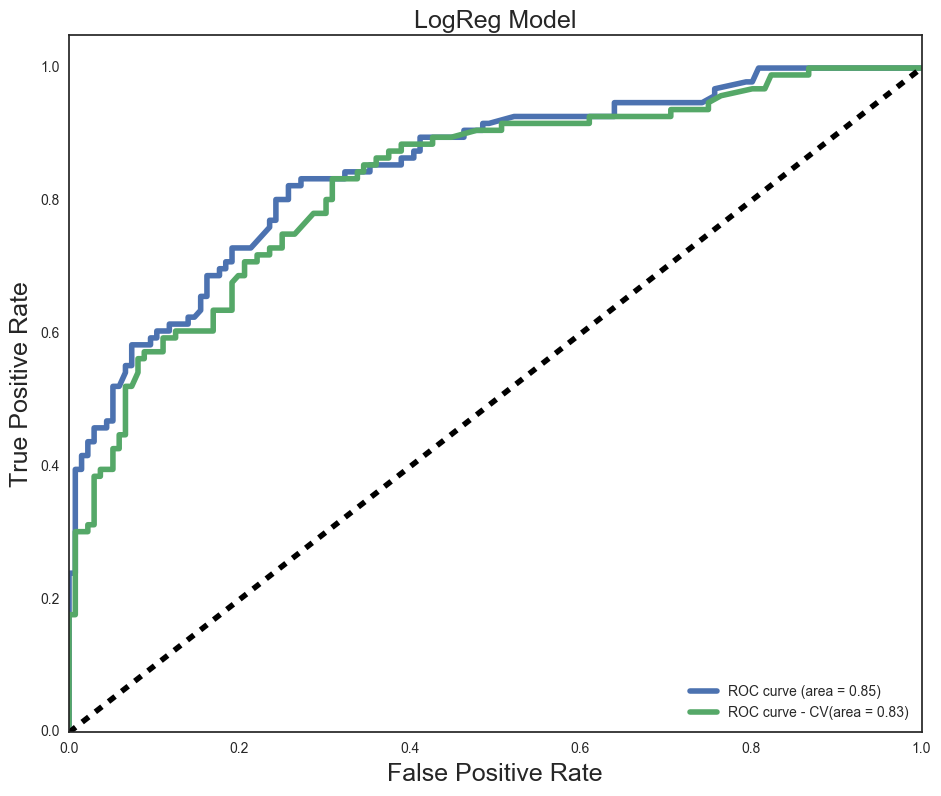

In [41]:
# DL. You can plot multiple ROC curves in one graph.
# It's easier for your audience to compare the two ROC curves

Y_score = logreg.decision_function(Xte)

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(yte, Y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])

Y_scoreCV = logregCV.decision_function(Xte)

FPRCV = dict()
TPRCV = dict()
ROC_AUCCV = dict()

# For class 1, find the area under the curve
FPRCV[1], TPRCV[1], _ = roc_curve(yte, Y_scoreCV)
ROC_AUCCV[1] = auc(FPRCV[1], TPRCV[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot(FPRCV[1], TPRCV[1], label='ROC curve - CV(area = %0.2f)' % ROC_AUCCV[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('LogReg Model', fontsize=18)
plt.legend(loc="lower right")
plt.show()

## Part 5: Gridsearch
Use GridSearchCV with logistic regression to search for optimal parameters.

In [42]:
from sklearn.grid_search import GridSearchCV
gsm = GridSearchCV(LogisticRegressionCV(solver='liblinear'), {
                                                                'Cs':np.arange(2,12,1), 
                                                                'cv':np.arange(2,17,1), 
                                                                'penalty':['l1','l2']
                                                             }, verbose=1, n_jobs=-1)
gsm.fit(X, y_ravel)
gsm.best_estimator_

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 764 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:   45.6s finished


LogisticRegressionCV(Cs=4, class_weight=None, cv=2, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='liblinear', tol=0.0001,
           verbose=0)

In [31]:
# compute difference between L1 (Lasso) and L2 (Ridge) penalties on model coefficients

lasso_model = LogisticRegression(penalty = 'l1', C=1.0)

print 'Lasso Metrics'
for metric in ['accuracy', 'precision', 'recall', 'roc_auc']:
    scores = cross_val_score(lasso_model, X, y_ravel, cv=11, scoring=metric)
    print(metric, scores.mean(), scores.std())

print   
print 'Ridge Metrics'
ridge_model = LogisticRegression(penalty = 'l2', C=1.0)

for metric in ['accuracy', 'precision', 'recall', 'roc_auc']:
    scores = cross_val_score(ridge_model, X, y_ravel, cv=11, scoring=metric)
    print(metric, scores.mean(), scores.std())
    
print

Lasso Metrics
('accuracy', 0.7742820559721969, 0.029336743507551579)
('precision', 0.74811170541437377, 0.042872209101537287)
('recall', 0.68652037617554862, 0.064853168857608792)
('roc_auc', 0.83820664897199793, 0.030748966927529382)

Ridge Metrics
('accuracy', 0.7807938540332906, 0.027492512078188217)
('precision', 0.76158388088672946, 0.039159086364543357)
('recall', 0.68652037617554862, 0.053933073774561927)
('roc_auc', 0.83774607786382371, 0.030353745701933527)



#### BONUS: Thresholds
You decide that you want to minimize false positives. Use the predicted probabilities from the model to set your threshold for labeling the positive class to need at least 90% confidence. How and why does this affect your confusion matrix?

## Part 6: Gridsearch and kNN
Perform Gridsearch for the same classification problem as above, but use KNeighborsClassifier as your estimator, and number of neighbors and weights as test parameters.

In [32]:
from sklearn.neighbors import KNeighborsClassifier
search_parameters = {
                     'n_neighbors':  [3,25,50], 
                     'weights':      ("uniform", "distance"),
                     'algorithm':    ("ball_tree", "kd_tree", "brute", "auto"),
                     'p':            [1,2]
                    }

knn = KNeighborsClassifier()

# Intialize GridSearchCV
clf = GridSearchCV(knn, search_parameters)

# Fit our training data
clf.fit(X, y_ravel)
clf_pred = clf.predict(Xte)

In [33]:
# print best parameters and score; is it better than original model?
print "Best Estimator:", clf.best_estimator_.n_neighbors
print "Best Params:", clf.best_params_
print "Best Score:", clf.best_score_

Best Estimator: 3
Best Params: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'ball_tree', 'p': 1}
Best Score: 0.736705577173


How does the number of neighbors affect the bias-variance tradeoff of your model? In what hypothetical scenarios might you prefer logistic regression over kNN, aside from model performance metrics?

In [34]:
# new confusion matrix; what has changed?
cm = confusion_matrix(yte, clf_pred)
print "logreg_confusion_matrix"
pd.DataFrame(cm, index=target_names, columns=['predicted_'+x for x in target_names])

logreg_confusion_matrix


,predicted_dead,predicted_survived
dead,126,10
survived,16,80


In [35]:
from sklearn.ensemble import BaggingClassifier

knn = KNeighborsClassifier()
bagging = BaggingClassifier(knn, max_samples=0.5, max_features=0.5)

print "KNN Score:\t", cross_val_score(knn, X, y_ravel, cv=5, n_jobs=-1).mean()
print "Bagging Score:\t", cross_val_score(bagging, X, y_ravel, cv=5, n_jobs=-1).mean()

KNN Score:	0.736736516699
Bagging Score:	0.726473572811


#### BONUS: Average Precision
Gridsearch the same parameters for logit but change scoring to 'average_precision' (optimizes parameters for area under the precision-recall curve instead of accuracy). Examine the best parameters, score, and confusion matrix. Are they different than the logistic regression gridsearch in part 5?

Plot the precision-recall curve. What does this tell us as opposed to the ROC curve?

#### BONUS: Decision Trees
Gridsearch a decision tree classifier model on the data, searching for optimal depth. Create a new decision tree model with the optimal parameters. Compare the performace of the decision tree model to the logistic regression and kNN models.

>Note: tie the data and 'disaster' theme to a specific problem statement and hypothesis. Use Tableau to tell the story where it makes most sense in your report. 

Score | 17/30
------|--------
Executive Summary |0
Posgres, SQL, Cleaning|3
Risks and Assumptions |0
Data Dictionary |0
EDA |2
Tableau Storyboard|0
Logit Model |3
Logit Metrics|3
Gridsearch |3
kNN |3
Bonus: Thresholds |0
Bonus: Average Precision|0
Bonus: Decision Trees|0


In [43]:
# DL. Great job with your models! 
# I think you should spend some time thinking through what your executive summary would look like. It's great practice.
# Also spend some time attempting the bonus questions.
# Let me know if you have any questions!